In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from pyod.models.abod import ABOD
from pyod.models.knn import KNN

from sklearn.linear_model import LinearRegression
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split

In [2]:
def replace_with_neighbor_mean(data, index, column):
    for i in range(len(index)) : 
        left_val = data.loc[index[i]-1][column]
        right_val = data.loc[index[i]+1][column]
        replace_val = 0
        if (left_val > 0) and (right_val > 0):
            replace_val = (left_val + right_val) / 2
        elif(left_val > 0):
            replace_val = left_val
        elif(right_val > 0):
            replace_val = right_val
        data.loc[index[i], column] = replace_val
    index = []                 
            

In [3]:
Data_WL = pd.read_pickle('F:\Learning\Bsc.IT(Hon)\Research Project\ShortTerm Model\Data\Maspotha_WL_Filtered_Hourly.pkl')

In [4]:
Data_RF = pd.read_pickle('F:\Learning\Bsc.IT(Hon)\Research Project\ShortTerm Model\Data\Lyceum_Filtered_Hourly.pkl')

In [5]:
Data_WL.head(5)

,water_height
date_time,
2019-02-23 00:00:00,0.293333
2019-02-23 01:00:00,0.291667
2019-02-23 02:00:00,0.288333
2019-02-23 03:00:00,0.290000
2019-02-23 04:00:00,0.291667


In [6]:
Data_RF.head(5)

,air-rainfall
DateTime,
2018-03-29 12:00:00,0.0
2018-03-29 13:00:00,0.0
2018-03-29 14:00:00,0.0
2018-03-29 15:00:00,0.0
2018-03-29 16:00:00,0.0


## Changing Column names

In [7]:
Data_WL.rename(columns={'date_time':'DateTime',
                     'water_height':'water-height'
                    }, 
                 inplace=True)

In [8]:
Data_WL.head(5)

,water-height
date_time,
2019-02-23 00:00:00,0.293333
2019-02-23 01:00:00,0.291667
2019-02-23 02:00:00,0.288333
2019-02-23 03:00:00,0.290000
2019-02-23 04:00:00,0.291667


In [9]:
Data_RF.head(5)

,air-rainfall
DateTime,
2018-03-29 12:00:00,0.0
2018-03-29 13:00:00,0.0
2018-03-29 14:00:00,0.0
2018-03-29 15:00:00,0.0
2018-03-29 16:00:00,0.0


## Merging 2 Data Frames

In [10]:
start = max(Data_WL.index.min(), Data_RF.index.min())
end = min(Data_WL.index.max(), Data_RF.index.max())

df_time = pd.DataFrame({'time': pd.date_range(start,end,freq='H')})

df_A = Data_RF.reset_index()
df_B = Data_WL.reset_index()
df_C = df_B.copy()

df_A.columns = ['time', 'rain-fall']
df_B.columns = ['time', 'water-level']
# df_C.columns = ['time', 'pre-water-level']

In [11]:
df_B.head(5)

,time,water-level
0,2019-02-23 00:00:00,0.293333
1,2019-02-23 01:00:00,0.291667
2,2019-02-23 02:00:00,0.288333
3,2019-02-23 03:00:00,0.290000
4,2019-02-23 04:00:00,0.291667


In [12]:
df = pd.merge(df_A, df_B, on='time', how='inner')
# df = pd.merge(df, df_C, on='time', how='inner')

In [13]:
df.shape

(5329, 3)

In [14]:
df.head()

,time,rain-fall,water-level
0,2019-02-23 00:00:00,0.0,0.293333
1,2019-02-23 01:00:00,0.0,0.291667
2,2019-02-23 02:00:00,0.0,0.288333
3,2019-02-23 03:00:00,0.0,0.290000
4,2019-02-23 04:00:00,0.0,0.291667


In [15]:
df_B.tail()

,time,water-level
5324,2019-10-02 20:00:00,1.066667
5325,2019-10-02 21:00:00,1.021667
5326,2019-10-02 22:00:00,0.986667
5327,2019-10-02 23:00:00,0.956000
5328,2019-10-03 00:00:00,0.930000


### Merging 6 hour lag

In [16]:
df_C = df_B.copy()
df_C.time = pd.to_datetime(df_C.time)

In [17]:
df_B.head(5)

,time,water-level
0,2019-02-23 00:00:00,0.293333
1,2019-02-23 01:00:00,0.291667
2,2019-02-23 02:00:00,0.288333
3,2019-02-23 03:00:00,0.290000
4,2019-02-23 04:00:00,0.291667


In [18]:
df_C.time = df_C.time - pd.DateOffset(hours=6)

In [19]:
df_C.head(5)

,time,water-level
0,2019-02-22 18:00:00,0.293333
1,2019-02-22 19:00:00,0.291667
2,2019-02-22 20:00:00,0.288333
3,2019-02-22 21:00:00,0.290000
4,2019-02-22 22:00:00,0.291667


In [20]:
df_C.columns = ['time', 'next-water-level']

In [21]:
df = pd.merge(df, df_C, on='time', how='inner')

In [22]:
df.shape

(5323, 4)

In [23]:
df.head(50)

,time,rain-fall,water-level,next-water-level
0,2019-02-23 00:00:00,0.0,0.293333,NaN
1,2019-02-23 01:00:00,0.0,0.291667,NaN
2,2019-02-23 02:00:00,0.0,0.288333,NaN
3,2019-02-23 03:00:00,0.0,0.290000,NaN
4,2019-02-23 04:00:00,0.0,0.291667,NaN
5,2019-02-23 05:00:00,0.0,0.290000,NaN
6,2019-02-23 06:00:00,0.0,NaN,NaN
7,2019-02-23 07:00:00,0.0,NaN,NaN
8,2019-02-23 08:00:00,0.0,NaN,NaN
9,2019-02-23 09:00:00,0.0,NaN,NaN


In [24]:
df.tail(50)

,time,rain-fall,water-level,next-water-level
5273,2019-09-30 17:00:00,0.0,NaN,0.330000
5274,2019-09-30 18:00:00,0.0,NaN,0.330000
5275,2019-09-30 19:00:00,0.0,0.331667,0.330000
5276,2019-09-30 20:00:00,0.0,0.328333,0.330000
5277,2019-09-30 21:00:00,0.0,0.338333,0.326667
5278,2019-09-30 22:00:00,0.0,0.331667,0.321667
5279,2019-09-30 23:00:00,0.0,0.330000,0.320000
5280,2019-10-01 00:00:00,0.0,0.330000,NaN
5281,2019-10-01 01:00:00,0.0,0.330000,NaN
5282,2019-10-01 02:00:00,0.0,0.330000,NaN


In [25]:
df = df.dropna()

In [26]:
df.head(50)

,time,rain-fall,water-level,next-water-level
19,2019-02-23 19:00:00,0.0,0.290000,0.288333
20,2019-02-23 20:00:00,0.0,0.283333,0.281667
21,2019-02-23 21:00:00,0.0,0.286667,0.280000
22,2019-02-23 22:00:00,0.0,0.291667,0.278333
23,2019-02-23 23:00:00,0.0,0.286667,0.276667
43,2019-02-24 19:00:00,0.0,0.280000,0.278333
44,2019-02-24 20:00:00,0.0,0.280000,0.278333
45,2019-02-24 21:00:00,0.0,0.283333,0.273333
46,2019-02-24 22:00:00,0.0,0.286667,0.270000
47,2019-02-24 23:00:00,0.0,0.280000,0.271667


## Outliers

## Changing Index

In [27]:
df = df.set_index('time')
df.index = pd.to_datetime(df.index)

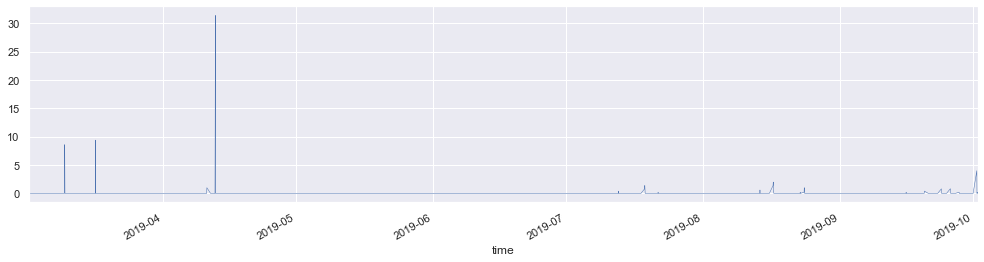

In [28]:
# Use seaborn style defaults and set the default figure size
sns.set(rc={'figure.figsize':(17, 4)})
df['2019-03-01':'2019-10-01']['rain-fall'].plot(linewidth=0.5);

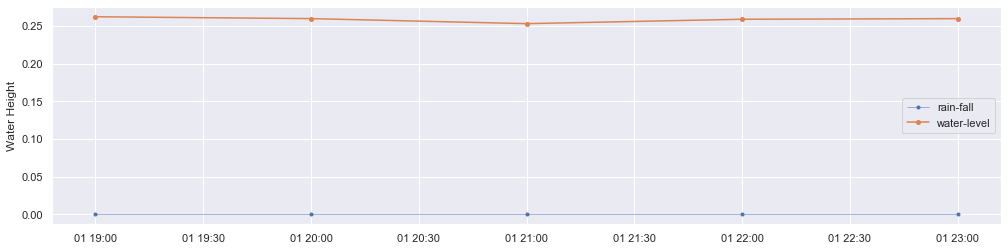

In [29]:
sns.set(rc={'figure.figsize':(17, 4)})
# Start and end of the date range to extract
start, end = '2019-03-01', '2019-03-01'
# Plot daily and weekly resampled time series together
fig, ax = plt.subplots()
ax.plot(df.loc[start:end, 'rain-fall'],
marker='.', linestyle='-', linewidth=0.5, label='rain-fall')
ax.plot(df.loc[start:end, 'water-level'],
marker='.', markersize=8, linestyle='-', label='water-level')
ax.set_ylabel('Water Height')
ax.legend();

In [30]:
df_filtered = df.between_time('19:00','05:00')

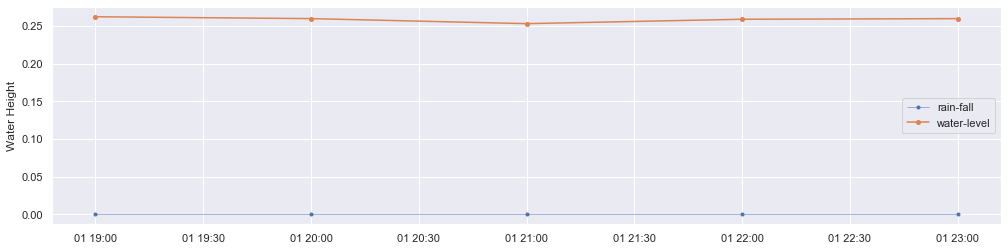

In [31]:
# Start and end of the date range to extract
start, end = '2019-03-01', '2019-03-01'
# Plot daily and weekly resampled time series together
fig, ax = plt.subplots()
ax.plot(df_filtered.loc[start:end, 'rain-fall'],
marker='.', linestyle='-', linewidth=0.5, label='rain-fall')
ax.plot(df_filtered.loc[start:end, 'water-level'],
marker='.', markersize=8, linestyle='-', label='water-level')
ax.set_ylabel('Water Height')
ax.legend();

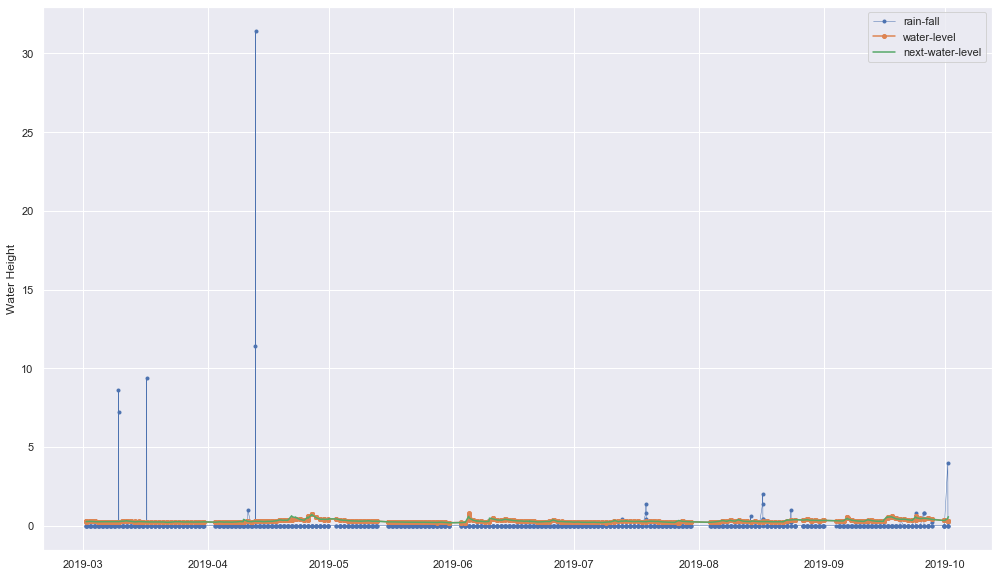

In [32]:
sns.set(rc={'figure.figsize':(17, 10)})
# Start and end of the date range to extract
start, end = '2019-03-01', '2019-10-01'
# Plot daily and weekly resampled time series together
fig, ax = plt.subplots()
ax.plot(df_filtered.loc[start:end, 'rain-fall'],
marker='.', linestyle='-', linewidth=0.5, label='rain-fall')
ax.plot(df_filtered.loc[start:end, 'water-level'],
marker='.', markersize=8, linestyle='-', label='water-level')
ax.plot(df_filtered.loc[start:end, 'next-water-level'],
marker='', markersize=8, linestyle='-', label='next-water-level')
ax.set_ylabel('Water Height')
ax.legend();

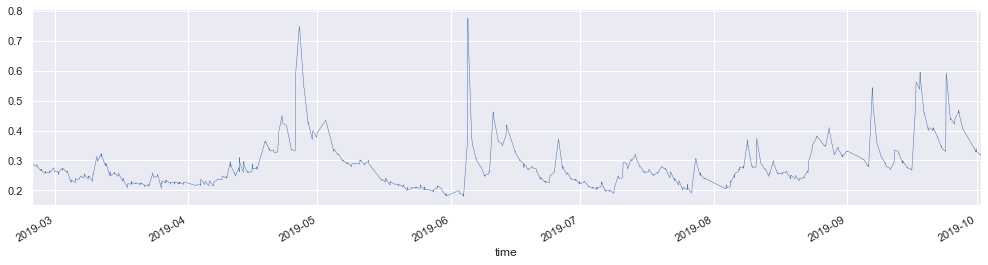

In [33]:
# Use seaborn style defaults and set the default figure size
sns.set(rc={'figure.figsize':(17, 4)})
df_filtered[:]['water-level'].plot(linewidth=0.5);

## Outliers

## Normalizing Rain Fall

In [34]:
temp_df = df_filtered.copy()
temp_df['rain-fall'] = ((df_filtered['rain-fall']-df_filtered['rain-fall'].min())/(df_filtered['rain-fall'].max()-df_filtered['rain-fall'].min()))*5

In [35]:
temp_df.sample(5)

,rain-fall,water-level,next-water-level
time,,,
2019-02-24 23:00:00,0.0,0.280000,0.271667
2019-07-23 21:00:00,0.0,0.230000,0.223333
2019-03-02 22:00:00,0.0,0.270000,0.263333
2019-05-22 23:00:00,0.0,0.208333,0.208333
2019-07-20 23:00:00,0.0,0.268333,0.261667


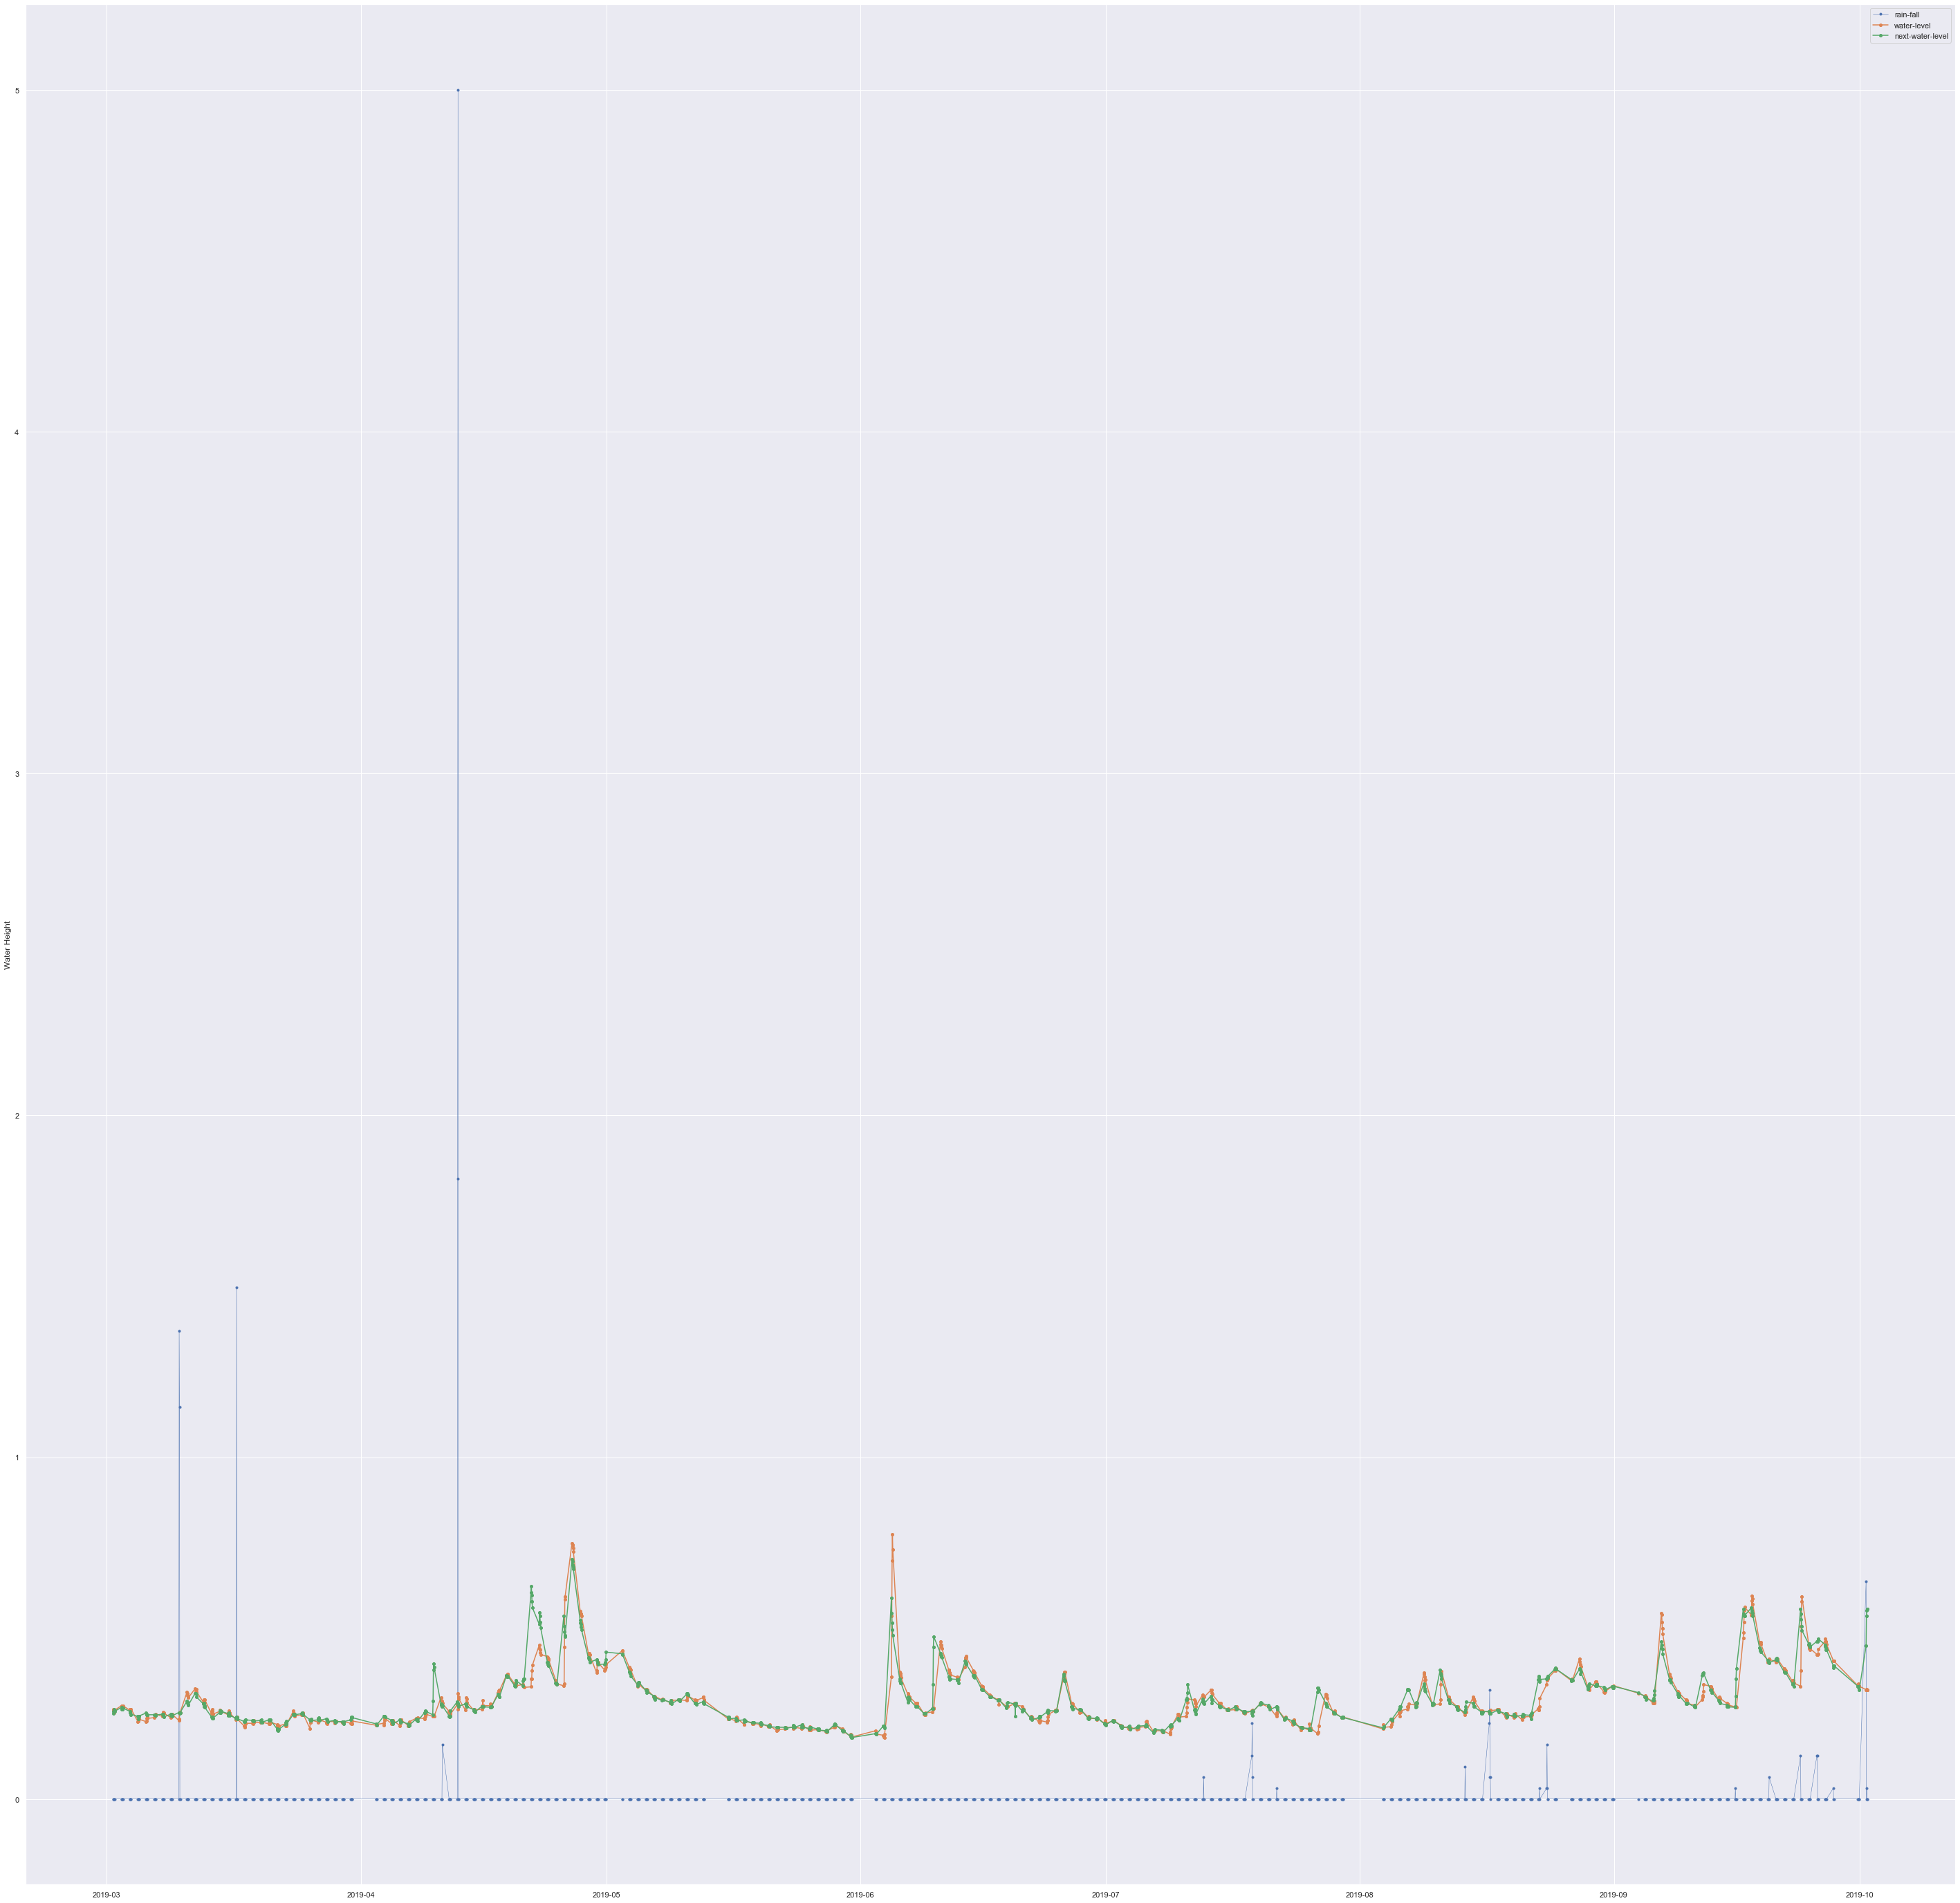

In [36]:
sns.set(rc={'figure.figsize':(50, 50)})
# Start and end of the date range to extract
start, end = '2019-03-01', '2019-10-01'
# Plot daily and weekly resampled time series together
fig, ax = plt.subplots()
ax.plot(temp_df.loc[start:end, 'rain-fall'],
marker='.', linestyle='-', linewidth=0.5, label='rain-fall')
ax.plot(temp_df.loc[start:end, 'water-level'],
marker='.', markersize=8, linestyle='-', label='water-level')
ax.plot(temp_df.loc[start:end, 'next-water-level'],
marker='.', markersize=8, linestyle='-', label='next-water-level')
ax.set_ylabel('Water Height')
ax.legend();

In [37]:
temp_df.tail(5)

,rain-fall,water-level,next-water-level
time,,,
2019-10-01 19:00:00,0.636943,0.320000,0.448000
2019-10-01 20:00:00,0.000000,0.320000,0.536667
2019-10-01 21:00:00,0.031847,0.321667,0.551667
2019-10-01 22:00:00,0.000000,0.318333,0.556667
2019-10-01 23:00:00,0.000000,0.318333,0.556667


In [38]:
temp_df.shape

(1010, 3)

## Linear Regression Model

In [39]:
# Build linear regression model using TV and Radio as predictors
# Split data into predictors X and output Y
predictors = ['rain-fall', 'water-level']
X = temp_df[predictors]
y = temp_df['next-water-level']

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train = X[:'2019-09-01']
X_test = X['2019-09-01':]
y_train = y[:'2019-09-01']
y_test = y['2019-09-01':]

In [40]:
y_test.head()

time
2019-09-03 23:00:00    0.311667
2019-09-04 19:00:00    0.300000
2019-09-04 20:00:00    0.300000
2019-09-04 21:00:00    0.300000
2019-09-04 22:00:00    0.296667
Name: next-water-level, dtype: float64

In [41]:
# Initialise and fit model
lm = LinearRegression()
model = lm.fit(X_train, y_train)

In [42]:
print(f'alpha = {model.intercept_}')
print(f'betas = {model.coef_}')

alpha = 0.036892175710221214
betas = [-0.00396668  0.87520208]


In [43]:
model.predict(X[:10])

array([0.29070078, 0.2848661 , 0.28778344, 0.29215945, 0.28778344,
       0.28194876, 0.28194876, 0.2848661 , 0.28778344, 0.28194876])

In [44]:
predictions = lm.predict(X_test)

In [45]:
predictions[0:5]

array([0.30820482, 0.30091147, 0.30237014, 0.30091147, 0.2994528 ])

## Testing results

In [47]:
y_test = y_test.reset_index()

y_test.columns = ['time', 'Observed']
# df_C.columns = ['time', 'pre-water-level']

In [48]:
y_test = y_test.set_index('time')
y_test.index = pd.to_datetime(y_test.index)

In [49]:
y_test['Predicted'] = predictions

In [50]:
y_test['2019-10']['Predicted']

time
2019-10-01 19:00:00    0.314430
2019-10-01 20:00:00    0.316957
2019-10-01 21:00:00    0.318289
2019-10-01 22:00:00    0.315498
2019-10-01 23:00:00    0.315498
Name: Predicted, dtype: float64

In [51]:
y_test.head()

,Observed,Predicted
time,,
2019-09-03 23:00:00,0.311667,0.308205
2019-09-04 19:00:00,0.300000,0.300911
2019-09-04 20:00:00,0.300000,0.302370
2019-09-04 21:00:00,0.300000,0.300911
2019-09-04 22:00:00,0.296667,0.299453


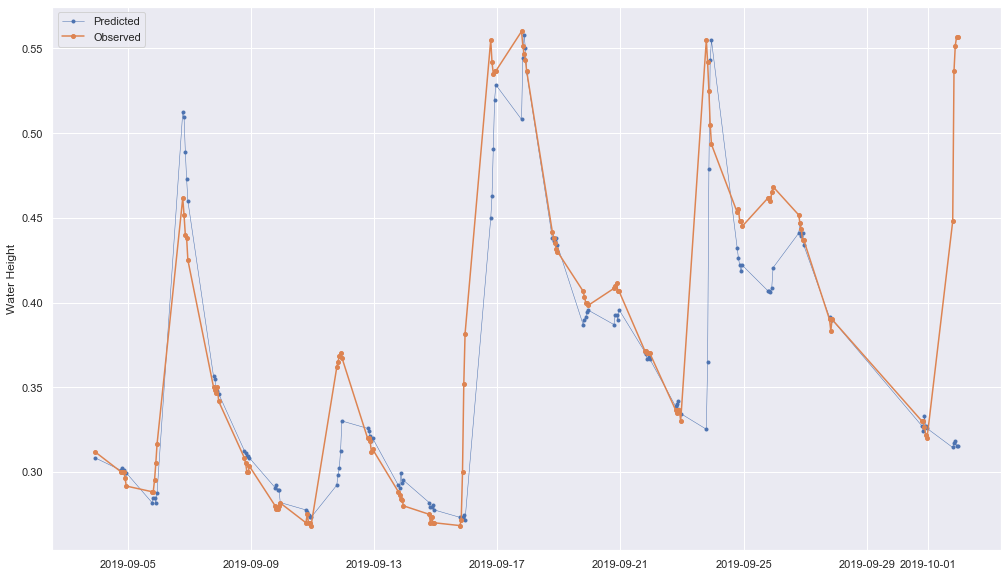

In [52]:
sns.set(rc={'figure.figsize':(17, 10)})
# Start and end of the date range to extract
# start, end = '2019-03-01', '2019-10-01'
# Plot daily and weekly resampled time series together
fig, ax = plt.subplots()
ax.plot(y_test.loc[:, 'Predicted'],
marker='.', linestyle='-', linewidth=0.5, label='Predicted')
ax.plot(y_test.loc[:, 'Observed'],
marker='.', markersize=8, linestyle='-', label='Observed')
ax.set_ylabel('Water Height')
ax.legend();

In [54]:
predictions.shape

(129,)